In [190]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline
import statsmodels.formula.api as smf 
import statsmodels.api as sm
import os

In [191]:
#Read in data and check data
os.getcwd()
testSet = pd.read_csv("data.txt", names = ["x1", "x2", "type"])
testSet.head()

,x1,x2,type
0,3.948420,-0.319132,1
1,5.913813,0.125970,1
2,-0.013082,5.295910,-1
3,-0.193497,5.823372,-1
4,1.193963,5.395064,-1


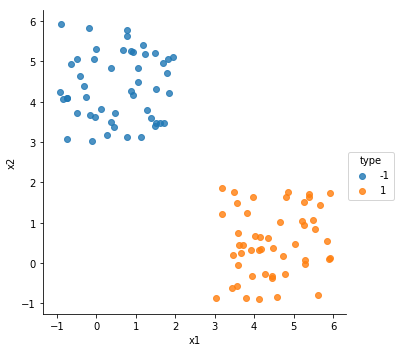

In [192]:
#Check data plot
sns.lmplot("x1", "x2", data=testSet, ci = None, hue="type", fit_reg=False)

In [193]:
#Loading in Harrington's SMO implementation
# %load SVMMLiA.py
'''
Created on Nov 4, 2010
Chapter 5 source file for Machine Learing in Action
@author: Peter
'''
from numpy import *
from time import sleep

def loadDataSet(fileName):
    dataMat = []; labelMat = []
    fr = open(fileName)
    for line in fr.readlines():
        lineArr = line.strip().split(',')
        dataMat.append([float(lineArr[0]), float(lineArr[1])])
        labelMat.append(float(lineArr[2]))
    return dataMat,labelMat

def selectJrand(i,m):
    j=i #we want to select any J not equal to i
    while (j==i):
        j = int(random.uniform(0,m))
    return j

def clipAlpha(aj,H,L):
    if aj > H: 
        aj = H
    if L > aj:
        aj = L
    return aj

def smoSimple(dataMatIn, classLabels, C, toler, maxIter):
    dataMatrix = mat(dataMatIn); labelMat = mat(classLabels).transpose()
    b = 0; m,n = shape(dataMatrix)
    alphas = mat(zeros((m,1)))
    iter = 0
    while (iter < maxIter):
        alphaPairsChanged = 0
        for i in range(m):
            fXi = float(multiply(alphas,labelMat).T*(dataMatrix*dataMatrix[i,:].T)) + b
            Ei = fXi - float(labelMat[i])#if checks if an example violates KKT conditions
            if ((labelMat[i]*Ei < -toler) and (alphas[i] < C)) or ((labelMat[i]*Ei > toler) and (alphas[i] > 0)):
                j = selectJrand(i,m)
                fXj = float(multiply(alphas,labelMat).T*(dataMatrix*dataMatrix[j,:].T)) + b
                Ej = fXj - float(labelMat[j])
                alphaIold = alphas[i].copy(); alphaJold = alphas[j].copy();
                if (labelMat[i] != labelMat[j]):
                    L = max(0, alphas[j] - alphas[i])
                    H = min(C, C + alphas[j] - alphas[i])
                else:
                    L = max(0, alphas[j] + alphas[i] - C)
                    H = min(C, alphas[j] + alphas[i])
                if L==H: print("L==H"); continue
                eta = 2.0 * dataMatrix[i,:]*dataMatrix[j,:].T - dataMatrix[i,:]*dataMatrix[i,:].T - dataMatrix[j,:]*dataMatrix[j,:].T
                if eta >= 0: print("eta>=0"); continue
                alphas[j] -= labelMat[j]*(Ei - Ej)/eta
                alphas[j] = clipAlpha(alphas[j],H,L)
                if (abs(alphas[j] - alphaJold) < 0.00001): print("j not moving enough"); continue
                alphas[i] += labelMat[j]*labelMat[i]*(alphaJold - alphas[j])#update i by the same amount as j
                                                                        #the update is in the oppostie direction
                b1 = b - Ei- labelMat[i]*(alphas[i]-alphaIold)*dataMatrix[i,:]*dataMatrix[i,:].T - labelMat[j]*(alphas[j]-alphaJold)*dataMatrix[i,:]*dataMatrix[j,:].T
                b2 = b - Ej- labelMat[i]*(alphas[i]-alphaIold)*dataMatrix[i,:]*dataMatrix[j,:].T - labelMat[j]*(alphas[j]-alphaJold)*dataMatrix[j,:]*dataMatrix[j,:].T
                if (0 < alphas[i]) and (C > alphas[i]): b = b1
                elif (0 < alphas[j]) and (C > alphas[j]): b = b2
                else: b = (b1 + b2)/2.0
                alphaPairsChanged += 1
                print("iter: %d i:%d, pairs changed %d" % (iter,i,alphaPairsChanged))
        if (alphaPairsChanged == 0): iter += 1
        else: iter = 0
        print("iteration number: %d" % iter)
    return b,alphas

def kernelTrans(X, A, kTup): #calc the kernel or transform data to a higher dimensional space
    m,n = shape(X)
    K = mat(zeros((m,1)))
    if kTup[0]=='lin': K = X * A.T   #linear kernel
    elif kTup[0]=='rbf':
        for j in range(m):
            deltaRow = X[j,:] - A
            K[j] = deltaRow*deltaRow.T
        K = exp(K/(-1*kTup[1]**2)) #divide in NumPy is element-wise not matrix like Matlab
    else: raise NameError('Houston We Have a Problem -- \
    That Kernel is not recognized')
    return K

class optStruct:
    def __init__(self,dataMatIn, classLabels, C, toler, kTup):  # Initialize the structure with the parameters 
        self.X = dataMatIn
        self.labelMat = classLabels
        self.C = C
        self.tol = toler
        self.m = shape(dataMatIn)[0]
        self.alphas = mat(zeros((self.m,1)))
        self.b = 0
        self.eCache = mat(zeros((self.m,2))) #first column is valid flag
        self.K = mat(zeros((self.m,self.m)))
        for i in range(self.m):
            self.K[:,i] = kernelTrans(self.X, self.X[i,:], kTup)
        
def calcEk(oS, k):
    fXk = float(multiply(oS.alphas,oS.labelMat).T*oS.K[:,k] + oS.b)
    Ek = fXk - float(oS.labelMat[k])
    return Ek
        
def selectJ(i, oS, Ei):         #this is the second choice -heurstic, and calcs Ej
    maxK = -1; maxDeltaE = 0; Ej = 0
    oS.eCache[i] = [1,Ei]  #set valid #choose the alpha that gives the maximum delta E
    validEcacheList = nonzero(oS.eCache[:,0].A)[0]
    if (len(validEcacheList)) > 1:
        for k in validEcacheList:   #loop through valid Ecache values and find the one that maximizes delta E
            if k == i: continue #don't calc for i, waste of time
            Ek = calcEk(oS, k)
            deltaE = abs(Ei - Ek)
            if (deltaE > maxDeltaE):
                maxK = k; maxDeltaE = deltaE; Ej = Ek
        return maxK, Ej
    else:   #in this case (first time around) we don't have any valid eCache values
        j = selectJrand(i, oS.m)
        Ej = calcEk(oS, j)
    return j, Ej

def updateEk(oS, k):#after any alpha has changed update the new value in the cache
    Ek = calcEk(oS, k)
    oS.eCache[k] = [1,Ek]
        
def innerL(i, oS):
    Ei = calcEk(oS, i)
    if ((oS.labelMat[i]*Ei < -oS.tol) and (oS.alphas[i] < oS.C)) or ((oS.labelMat[i]*Ei > oS.tol) and (oS.alphas[i] > 0)):
        j,Ej = selectJ(i, oS, Ei) #this has been changed from selectJrand
        alphaIold = oS.alphas[i].copy(); alphaJold = oS.alphas[j].copy();
        if (oS.labelMat[i] != oS.labelMat[j]):
            L = max(0, oS.alphas[j] - oS.alphas[i])
            H = min(oS.C, oS.C + oS.alphas[j] - oS.alphas[i])
        else:
            L = max(0, oS.alphas[j] + oS.alphas[i] - oS.C)
            H = min(oS.C, oS.alphas[j] + oS.alphas[i])
        if L==H: print("L==H"); return 0
        eta = 2.0 * oS.K[i,j] - oS.K[i,i] - oS.K[j,j] #changed for kernel
        if eta >= 0: print("eta>=0"); return 0
        oS.alphas[j] -= oS.labelMat[j]*(Ei - Ej)/eta
        oS.alphas[j] = clipAlpha(oS.alphas[j],H,L)
        updateEk(oS, j) #added this for the Ecache
        if (abs(oS.alphas[j] - alphaJold) < 0.00001): print("j not moving enough"); return 0
        oS.alphas[i] += oS.labelMat[j]*oS.labelMat[i]*(alphaJold - oS.alphas[j])#update i by the same amount as j
        updateEk(oS, i) #added this for the Ecache                    #the update is in the oppostie direction
        b1 = oS.b - Ei- oS.labelMat[i]*(oS.alphas[i]-alphaIold)*oS.K[i,i] - oS.labelMat[j]*(oS.alphas[j]-alphaJold)*oS.K[i,j]
        b2 = oS.b - Ej- oS.labelMat[i]*(oS.alphas[i]-alphaIold)*oS.K[i,j]- oS.labelMat[j]*(oS.alphas[j]-alphaJold)*oS.K[j,j]
        if (0 < oS.alphas[i]) and (oS.C > oS.alphas[i]): oS.b = b1
        elif (0 < oS.alphas[j]) and (oS.C > oS.alphas[j]): oS.b = b2
        else: oS.b = (b1 + b2)/2.0
        return 1
    else: return 0

def smoP(dataMatIn, classLabels, C, toler, maxIter,kTup=('lin', 0)):    #full Platt SMO
    oS = optStruct(mat(dataMatIn),mat(classLabels).transpose(),C,toler, kTup)
    iter = 0
    entireSet = True; alphaPairsChanged = 0
    while (iter < maxIter) and ((alphaPairsChanged > 0) or (entireSet)):
        alphaPairsChanged = 0
        if entireSet:   #go over all
            for i in range(oS.m):        
                alphaPairsChanged += innerL(i,oS)
                print("fullSet, iter: %d i:%d, pairs changed %d" % (iter,i,alphaPairsChanged))
            iter += 1
        else:#go over non-bound (railed) alphas
            nonBoundIs = nonzero((oS.alphas.A > 0) * (oS.alphas.A < C))[0]
            for i in nonBoundIs:
                alphaPairsChanged += innerL(i,oS)
                print("non-bound, iter: %d i:%d, pairs changed %d" % (iter,i,alphaPairsChanged))
            iter += 1
        if entireSet: entireSet = False #toggle entire set loop
        elif (alphaPairsChanged == 0): entireSet = True  
        print("iteration number: %d" % iter)
    return oS.b,oS.alphas

def calcWs(alphas,dataArr,classLabels):
    X = mat(dataArr); labelMat = mat(classLabels).transpose()
    m,n = shape(X)
    w = zeros((n,1))
    for i in range(m):
        w += multiply(alphas[i]*labelMat[i],X[i,:].T)
    return w

def testRbf(k1=1.3):
    dataArr,labelArr = loadDataSet('testSetRBF.txt')
    b,alphas = smoP(dataArr, labelArr, 200, 0.0001, 10000, ('rbf', k1)) #C=200 important
    datMat=mat(dataArr); labelMat = mat(labelArr).transpose()
    svInd=nonzero(alphas.A>0)[0]
    sVs=datMat[svInd] #get matrix of only support vectors
    labelSV = labelMat[svInd];
    print("there are %d Support Vectors" % shape(sVs)[0])
    m,n = shape(datMat)
    errorCount = 0
    for i in range(m):
        kernelEval = kernelTrans(sVs,datMat[i,:],('rbf', k1))
        predict=kernelEval.T * multiply(labelSV,alphas[svInd]) + b
        if sign(predict)!=sign(labelArr[i]): errorCount += 1
    print("the training error rate is: %f" % (float(errorCount)/m))
    dataArr,labelArr = loadDataSet('testSetRBF2.txt')
    errorCount = 0
    datMat=mat(dataArr); labelMat = mat(labelArr).transpose()
    m,n = shape(datMat)
    for i in range(m):
        kernelEval = kernelTrans(sVs,datMat[i,:],('rbf', k1))
        predict=kernelEval.T * multiply(labelSV,alphas[svInd]) + b
        if sign(predict)!=sign(labelArr[i]): errorCount += 1    
    print("the test error rate is: %f" % (float(errorCount)/m))    
    
def img2vector(filename):
    returnVect = zeros((1,1024))
    fr = open(filename)
    for i in range(32):
        lineStr = fr.readline()
        for j in range(32):
            returnVect[0,32*i+j] = int(lineStr[j])
    return returnVect

def loadImages(dirName):
    from os import listdir
    hwLabels = []
    trainingFileList = listdir(dirName)           #load the training set
    m = len(trainingFileList)
    trainingMat = zeros((m,1024))
    for i in range(m):
        fileNameStr = trainingFileList[i]
        fileStr = fileNameStr.split('.')[0]     #take off .txt
        classNumStr = int(fileStr.split('_')[0])
        if classNumStr == 9: hwLabels.append(-1)
        else: hwLabels.append(1)
        trainingMat[i,:] = img2vector('%s/%s' % (dirName, fileNameStr))
    return trainingMat, hwLabels    

def testDigits(kTup=('rbf', 10)):
    dataArr,labelArr = loadImages('trainingDigits')
    b,alphas = smoP(dataArr, labelArr, 200, 0.0001, 10000, kTup)
    datMat=mat(dataArr); labelMat = mat(labelArr).transpose()
    svInd=nonzero(alphas.A>0)[0]
    sVs=datMat[svInd] 
    labelSV = labelMat[svInd];
    print("there are %d Support Vectors" % shape(sVs)[0])
    m,n = shape(datMat)
    errorCount = 0
    for i in range(m):
        kernelEval = kernelTrans(sVs,datMat[i,:],kTup)
        predict=kernelEval.T * multiply(labelSV,alphas[svInd]) + b
        if sign(predict)!=sign(labelArr[i]): errorCount += 1
    print("the training error rate is: %f" % (float(errorCount)/m))
    dataArr,labelArr = loadImages('testDigits')
    errorCount = 0
    datMat=mat(dataArr); labelMat = mat(labelArr).transpose()
    m,n = shape(datMat)
    for i in range(m):
        kernelEval = kernelTrans(sVs,datMat[i,:],kTup)
        predict=kernelEval.T * multiply(labelSV,alphas[svInd]) + b
        if sign(predict)!=sign(labelArr[i]): errorCount += 1    
    print("the test error rate is: %f" % (float(errorCount)/m)) 


'''#######********************************
Non-Kernel VErsions below
'''#######********************************

class optStructK:
    def __init__(self,dataMatIn, classLabels, C, toler):  # Initialize the structure with the parameters 
        self.X = dataMatIn
        self.labelMat = classLabels
        self.C = C
        self.tol = toler
        self.m = shape(dataMatIn)[0]
        self.alphas = mat(zeros((self.m,1)))
        self.b = 0
        self.eCache = mat(zeros((self.m,2))) #first column is valid flag
        
def calcEkK(oS, k):
    fXk = float(multiply(oS.alphas,oS.labelMat).T*(oS.X*oS.X[k,:].T)) + oS.b
    Ek = fXk - float(oS.labelMat[k])
    return Ek
        
def selectJK(i, oS, Ei):         #this is the second choice -heurstic, and calcs Ej
    maxK = -1; maxDeltaE = 0; Ej = 0
    oS.eCache[i] = [1,Ei]  #set valid #choose the alpha that gives the maximum delta E
    validEcacheList = nonzero(oS.eCache[:,0].A)[0]
    if (len(validEcacheList)) > 1:
        for k in validEcacheList:   #loop through valid Ecache values and find the one that maximizes delta E
            if k == i: continue #don't calc for i, waste of time
            Ek = calcEkK(oS, k)
            deltaE = abs(Ei - Ek)
            if (deltaE > maxDeltaE):
                maxK = k; maxDeltaE = deltaE; Ej = Ek
        return maxK, Ej
    else:   #in this case (first time around) we don't have any valid eCache values
        j = selectJrand(i, oS.m)
        Ej = calcEkK(oS, j)
    return j, Ej

def updateEkK(oS, k):#after any alpha has changed update the new value in the cache
    Ek = calcEkK(oS, k)
    oS.eCache[k] = [1,Ek]
        
def innerLK(i, oS):
    Ei = calcEkK(oS, i)
    if ((oS.labelMat[i]*Ei < -oS.tol) and (oS.alphas[i] < oS.C)) or ((oS.labelMat[i]*Ei > oS.tol) and (oS.alphas[i] > 0)):
        j,Ej = selectJK(i, oS, Ei) #this has been changed from selectJrand
        alphaIold = oS.alphas[i].copy(); alphaJold = oS.alphas[j].copy();
        if (oS.labelMat[i] != oS.labelMat[j]):
            L = max(0, oS.alphas[j] - oS.alphas[i])
            H = min(oS.C, oS.C + oS.alphas[j] - oS.alphas[i])
        else:
            L = max(0, oS.alphas[j] + oS.alphas[i] - oS.C)
            H = min(oS.C, oS.alphas[j] + oS.alphas[i])
        if L==H: print("L==H"); return 0
        eta = 2.0 * oS.X[i,:]*oS.X[j,:].T - oS.X[i,:]*oS.X[i,:].T - oS.X[j,:]*oS.X[j,:].T
        if eta >= 0: print("eta>=0"); return 0
        oS.alphas[j] -= oS.labelMat[j]*(Ei - Ej)/eta
        oS.alphas[j] = clipAlpha(oS.alphas[j],H,L)
        updateEkK(oS, j) #added this for the Ecache
        if (abs(oS.alphas[j] - alphaJold) < 0.00001): print("j not moving enough"); return 0
        oS.alphas[i] += oS.labelMat[j]*oS.labelMat[i]*(alphaJold - oS.alphas[j])#update i by the same amount as j
        updateEkK(oS, i) #added this for the Ecache                    #the update is in the oppostie direction
        b1 = oS.b - Ei- oS.labelMat[i]*(oS.alphas[i]-alphaIold)*oS.X[i,:]*oS.X[i,:].T - oS.labelMat[j]*(oS.alphas[j]-alphaJold)*oS.X[i,:]*oS.X[j,:].T
        b2 = oS.b - Ej- oS.labelMat[i]*(oS.alphas[i]-alphaIold)*oS.X[i,:]*oS.X[j,:].T - oS.labelMat[j]*(oS.alphas[j]-alphaJold)*oS.X[j,:]*oS.X[j,:].T
        if (0 < oS.alphas[i]) and (oS.C > oS.alphas[i]): oS.b = b1
        elif (0 < oS.alphas[j]) and (oS.C > oS.alphas[j]): oS.b = b2
        else: oS.b = (b1 + b2)/2.0
        return 1
    else: return 0

def smoPK(dataMatIn, classLabels, C, toler, maxIter):    #full Platt SMO
    oS = optStructK(mat(dataMatIn),mat(classLabels).transpose(),C,toler)
    iter = 0
    entireSet = True; alphaPairsChanged = 0
    while (iter < maxIter) and ((alphaPairsChanged > 0) or (entireSet)):
        alphaPairsChanged = 0
        if entireSet:   #go over all
            for i in range(oS.m):        
                alphaPairsChanged += innerLK(i,oS)
                print("fullSet, iter: %d i:%d, pairs changed %d" % (iter,i,alphaPairsChanged))
            iter += 1
        else:#go over non-bound (railed) alphas
            nonBoundIs = nonzero((oS.alphas.A > 0) * (oS.alphas.A < C))[0]
            for i in nonBoundIs:
                alphaPairsChanged += innerLK(i,oS)
                print("non-bound, iter: %d i:%d, pairs changed %d" % (iter,i,alphaPairsChanged))
            iter += 1
        if entireSet: entireSet = False #toggle entire set loop
        elif (alphaPairsChanged == 0): entireSet = True  
        print("iteration number: %d" % iter)
    return oS.b,oS.alphas

In [183]:
#Creating class svm_basic - Lab2 starts here
class svm_basic:
    
    #Constructor
    def __init__(self, C = 1, toler = 0.001, maxIter = 50):
        self.C = C
        self.toler = toler
        self.maxIter = maxIter
        
    #Fit function - inputs data Matrix and Class Labels    
    def fit(self, X, Y): 
        self.b, self.alphas = smoPK(X, Y, self.C, self.toler, self.maxIter)
        #print(self.alphas)
        self.w = calcWs(self.alphas, X, Y)
        return 
    
    #Predict function - inputs test Matrix 
    #Uses hyperplane function
    def predict(self, X):
        from numpy import dot
        
        result = dot(self.w.T,X) + self.b
        return result
        


In [197]:
#Main Method execution 
#Load in dataset - assigns to two lists
#dataMatIn 
#classLabels
dataMatIn, classLabels = loadDataSet('data.txt')

#Initialise class - my_model
my_model = svm_basic()

#Fit data 
my_model.fit(dataMatIn, classLabels)

#Splitting data into ratio 1:4 - test_size = 20%
#Predict data on test set: test_set == X_test
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(dataMatIn, classLabels, test_size=0.2, random_state=121)
test_set = np.array(X_test)
result = my_model.predict(test_set.T)

#Declare classification list for test results
classification = []
for a in np.nditer(result):
    if a >= 0 :
        classification.append(1)
    else :
        classification.append(-1)
print(classification)    

L==H
fullSet, iter: 0 i:0, pairs changed 0
L==H
fullSet, iter: 0 i:1, pairs changed 0
fullSet, iter: 0 i:2, pairs changed 1
fullSet, iter: 0 i:3, pairs changed 1
fullSet, iter: 0 i:4, pairs changed 2
L==H
fullSet, iter: 0 i:5, pairs changed 2
fullSet, iter: 0 i:6, pairs changed 2
L==H
fullSet, iter: 0 i:7, pairs changed 2
fullSet, iter: 0 i:8, pairs changed 3
fullSet, iter: 0 i:9, pairs changed 3
fullSet, iter: 0 i:10, pairs changed 3
fullSet, iter: 0 i:11, pairs changed 4
j not moving enough
fullSet, iter: 0 i:12, pairs changed 4
j not moving enough
fullSet, iter: 0 i:13, pairs changed 4
fullSet, iter: 0 i:14, pairs changed 4
fullSet, iter: 0 i:15, pairs changed 4
j not moving enough
fullSet, iter: 0 i:16, pairs changed 4
fullSet, iter: 0 i:17, pairs changed 4
fullSet, iter: 0 i:18, pairs changed 5
fullSet, iter: 0 i:19, pairs changed 5
fullSet, iter: 0 i:20, pairs changed 5
fullSet, iter: 0 i:21, pairs changed 5
fullSet, iter: 0 i:22, pairs changed 5
fullSet, iter: 0 i:23, pairs chan

          x1        x2  Class
0   4.846514  1.772123      1
1   0.933640  5.224675     -1
2   0.874154  5.254460     -1
3   4.455876 -0.309145      1
4   1.495002  3.398053     -1
5   3.970198  1.635354      1
6   5.266461  0.934631      1
7   0.786590  5.769403     -1
8   5.388044  1.702283      1
9   1.844324  4.208922     -1
10  1.933917  5.098318     -1
11 -0.838550  4.068960     -1
12  3.039194 -0.872500      1
13  5.858049  0.554408      1
14  3.788795 -0.856824      1
15  0.370945  3.490625     -1
16  1.800717  4.719398     -1
17  5.905040  0.098958      1
18 -0.019964  3.623664     -1
19  0.461192  3.379534     -1


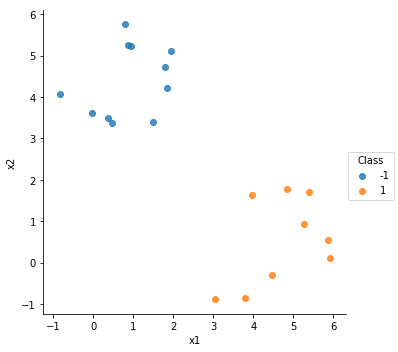

In [201]:
#Placing test_data into DataFrame
#Placing classification data into DataFrame
testDF = pd.DataFrame(X_test, columns= ['x1','x2'])
classDF = pd.DataFrame(classification, columns =['Class'])

#Combining DataFrames into one - finalResult
frames = [testDF, classDF]
finalResult = pd.concat(frames, axis = 1)
print(finalResult)

#Plot new data on finalResult
sns.lmplot('x1', 'x2', data=finalResult, ci = None, hue="Class", fit_reg=False)